In [1]:
import torch
import numpy as np
import syft as sy
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset as FederatedDataset
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

unsupported operand type(s) for |: 'type' and 'NoneType'


C:\Users\ek\miniconda3\envs\help\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
url = 'https://raw.githubusercontent.com/samhithanair/Energy-Consumption-Using-LSTM-and-Federated-Learning/main/Household_electricity_dataset.csv'
df = pd.read_csv(url)

In [47]:
df

,Date,Value,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,...,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipitation,day_of_week,Day.1
0,01-06-2016,29.691,1,85,73.8,68,74,71.4,66,100,...,65,21,9.5,0,29.8,29.8,29.7,0.00,2,1
1,02-06-2016,28.789,2,76,71.2,66,74,70.3,66,100,...,89,18,7.8,0,29.8,29.8,29.7,4.33,5,2
2,03-06-2016,19.247,3,79,72.1,68,73,70.0,68,100,...,72,18,4.7,0,29.8,29.8,29.7,3.18,6,3
3,04-06-2016,22.883,4,76,71.2,69,73,70.0,66,100,...,85,20,7.0,0,29.8,29.7,29.7,2.37,2,4
4,05-06-2016,25.195,5,82,73.8,68,72,70.0,68,100,...,62,17,7.7,0,29.7,29.7,29.7,0.39,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,03-07-2020,39.659,3,96,84.7,74,76,72.8,67,91,...,38,24,6.3,0,29.9,29.9,29.8,0.00,5,1494
1494,04-07-2020,38.071,4,97,84.6,73,76,72.9,70,94,...,43,10,3.6,0,29.9,29.8,29.7,0.00,1,1495
1495,05-07-2020,36.565,5,95,85.4,79,75,73.5,68,88,...,44,12,6.2,0,29.8,29.7,29.7,0.00,3,1496
1496,06-07-2020,39.900,6,91,85.5,82,77,75.5,72,82,...,59,10,6.0,0,29.8,29.8,29.7,0.00,6,1497


In [48]:
df_numeric = df.select_dtypes(include=[np.number])

In [49]:
X = df_numeric.drop(columns=['Value'])
y = df_numeric['Value']

In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
split_idx1 = len(X_scaled) // 3
split_idx2 = 2 * len(X_scaled) // 3

In [56]:
X_c1 = X_scaled[:split_idx1]
X_c2 = X_scaled[split_idx1:split_idx2]
X_c3 = X_scaled[split_idx2:]

In [57]:
y_c1 = y[:split_idx1].values.reshape(-1, 1)
y_c2 = y[split_idx1:split_idx2].values.reshape(-1, 1)
y_c3 = y[split_idx2:].values.reshape(-1, 1)

In [58]:
X_c1_tensor = torch.tensor(X_c1, dtype=torch.float32)
X_c2_tensor = torch.tensor(X_c2, dtype=torch.float32)
X_c3_tensor = torch.tensor(X_c3, dtype=torch.float32)

y_c1_tensor = torch.tensor(y_c1, dtype=torch.float32)
y_c2_tensor = torch.tensor(y_c2, dtype=torch.float32)
y_c3_tensor = torch.tensor(y_c3, dtype=torch.float32)

In [59]:
dataset_c1 = FederatedDataset(X_c1_tensor, y_c1_tensor)
dataset_c2 = FederatedDataset(X_c2_tensor, y_c2_tensor)
dataset_c3 = FederatedDataset(X_c3_tensor, y_c3_tensor)

In [60]:
batch_size = 64

In [61]:
dataloader_c1 = DataLoader(dataset_c1, batch_size=batch_size, shuffle=True)
dataloader_c2 = DataLoader(dataset_c2, batch_size=batch_size, shuffle=True)
dataloader_c3 = DataLoader(dataset_c3, batch_size=batch_size, shuffle=True)

In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [63]:
input_size = X_c1_tensor.shape[1]
hidden_size = 16
output_size = 1
input_size

19

In [64]:
model = LSTMModel(input_size, hidden_size, output_size)
model_c1 = LSTMModel(input_size, hidden_size, output_size)
model_c2 = LSTMModel(input_size, hidden_size, output_size)
model_c3 = LSTMModel(input_size, hidden_size, output_size)

In [65]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
import matplotlib.pyplot as plt

def train(model,dataloader):
    epochs = 1000
    loss_values = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data in [dataloader_c1]:
            for inputs, labels in data:
                optimizer.zero_grad()
                outputs = model(inputs.unsqueeze(1))
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss*0.0001}")
        loss_values.append(running_loss*0.0001)
    
    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

Epoch 1, Loss: 0.6277204833984376
Epoch 2, Loss: 0.6271926147460938
Epoch 3, Loss: 0.6260134216308594
Epoch 4, Loss: 0.6286430847167969
Epoch 5, Loss: 0.6279252990722657
Epoch 6, Loss: 0.6289388610839844
Epoch 7, Loss: 0.6271499206542969
Epoch 8, Loss: 0.6285647644042969
Epoch 9, Loss: 0.6288408935546875
Epoch 10, Loss: 0.6275111572265625
Epoch 11, Loss: 0.6344681213378907
Epoch 12, Loss: 0.6278742980957032
Epoch 13, Loss: 0.6310010498046875
Epoch 14, Loss: 0.6286655883789063
Epoch 15, Loss: 0.6277189636230469
Epoch 16, Loss: 0.6299496826171875
Epoch 17, Loss: 0.6297616333007813
Epoch 18, Loss: 0.6271504882812501
Epoch 19, Loss: 0.6313578002929687
Epoch 20, Loss: 0.6313055847167969
Epoch 21, Loss: 0.6306991394042969
Epoch 22, Loss: 0.6317590759277344
Epoch 23, Loss: 0.6331810668945312
Epoch 24, Loss: 0.6257902954101563
Epoch 25, Loss: 0.6294181579589844
Epoch 26, Loss: 0.6337706542968751
Epoch 27, Loss: 0.6271374084472656
Epoch 28, Loss: 0.6308880615234376
Epoch 29, Loss: 0.63098936767

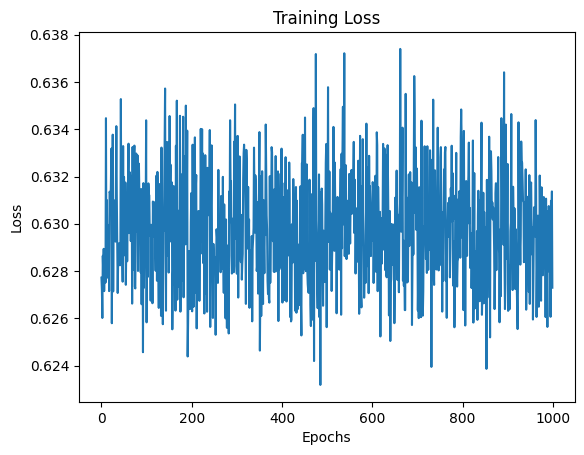

CPU times: total: 55.1 s
Wall time: 49.4 s


In [67]:
%%time
train(model_c1,dataloader_c1)

Epoch 1, Loss: 0.6273591003417969
Epoch 2, Loss: 0.6274774047851562
Epoch 3, Loss: 0.6292908874511719
Epoch 4, Loss: 0.6308125793457031
Epoch 5, Loss: 0.6324088195800781
Epoch 6, Loss: 0.6278148681640625
Epoch 7, Loss: 0.6294359008789063
Epoch 8, Loss: 0.63353330078125
Epoch 9, Loss: 0.6301741088867188
Epoch 10, Loss: 0.628341082763672
Epoch 11, Loss: 0.6275518371582032
Epoch 12, Loss: 0.6346889038085938
Epoch 13, Loss: 0.6298408813476563
Epoch 14, Loss: 0.6260764770507813
Epoch 15, Loss: 0.6282264526367188
Epoch 16, Loss: 0.6284269348144531
Epoch 17, Loss: 0.6292599792480469
Epoch 18, Loss: 0.6301062988281251
Epoch 19, Loss: 0.626388232421875
Epoch 20, Loss: 0.6260032836914062
Epoch 21, Loss: 0.6275755737304688
Epoch 22, Loss: 0.6311024475097656
Epoch 23, Loss: 0.6301963745117187
Epoch 24, Loss: 0.629310565185547
Epoch 25, Loss: 0.6294639282226563
Epoch 26, Loss: 0.6302502197265625
Epoch 27, Loss: 0.6273144653320313
Epoch 28, Loss: 0.6277361145019531
Epoch 29, Loss: 0.6334914367675781

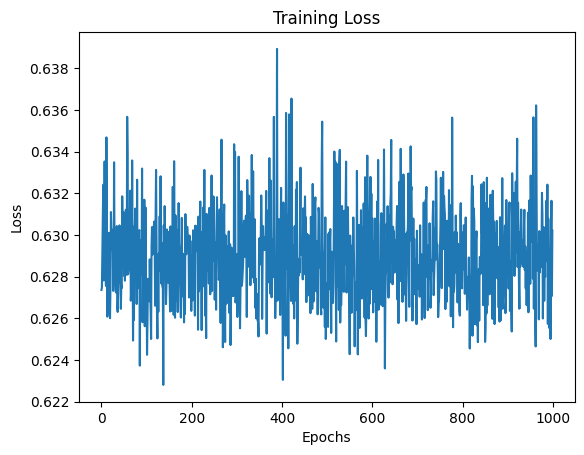

CPU times: total: 57.1 s
Wall time: 48.7 s


In [68]:
%%time
train(model_c2,dataloader_c2)

Epoch 1, Loss: 0.6349860778808594
Epoch 2, Loss: 0.6299147827148438
Epoch 3, Loss: 0.6349087524414063
Epoch 4, Loss: 0.6311213684082032
Epoch 5, Loss: 0.6289254455566406
Epoch 6, Loss: 0.6288669494628907
Epoch 7, Loss: 0.6271170776367188
Epoch 8, Loss: 0.6332979858398438
Epoch 9, Loss: 0.6294022399902344
Epoch 10, Loss: 0.6280011535644532
Epoch 11, Loss: 0.6332283935546875
Epoch 12, Loss: 0.6359005981445313
Epoch 13, Loss: 0.6273632995605469
Epoch 14, Loss: 0.6328197631835938
Epoch 15, Loss: 0.6283018188476562
Epoch 16, Loss: 0.6364769287109375
Epoch 17, Loss: 0.6331530334472657
Epoch 18, Loss: 0.6321950378417969
Epoch 19, Loss: 0.6311710754394532
Epoch 20, Loss: 0.6319277709960938
Epoch 21, Loss: 0.6353890014648438
Epoch 22, Loss: 0.6348802062988281
Epoch 23, Loss: 0.6327044494628906
Epoch 24, Loss: 0.6338000427246094
Epoch 25, Loss: 0.6322404907226563
Epoch 26, Loss: 0.6275565002441407
Epoch 27, Loss: 0.6331463134765626
Epoch 28, Loss: 0.6338619689941406
Epoch 29, Loss: 0.63229621582

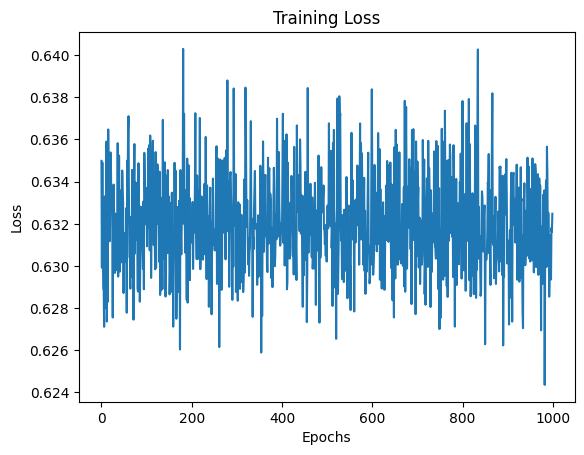

CPU times: total: 56 s
Wall time: 50.4 s


In [69]:
%%time
train(model_c3,dataloader_c3)

In [70]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.unsqueeze(1))
            predictions.append(outputs.detach().numpy())
    return np.vstack(predictions)

In [71]:
predictions_c1 = predict(model_c1, dataloader_c1)
predictions_c2 = predict(model_c2, dataloader_c2)
predictions_c3 = predict(model_c3, dataloader_c3)

In [73]:
print("Predictions for dataset_c1:", predictions_c1[-1])
print("Predictions for dataset_c2:", predictions_c2[-1])
print("Predictions for dataset_c3:", predictions_c3[-1])

Predictions for dataset_c1: [0.10436004]
Predictions for dataset_c2: [0.13634472]
Predictions for dataset_c3: [0.03512851]


In [74]:
global_avg_prediction

0.09290295094251633

In [75]:
df_numeric_scaled = scaler.fit_transform(df_numeric)
y = df_numeric_scaled[:, -1]

yc1 = y[:split_idx1]
yc2 = y[split_idx1:split_idx2]
yc3 = y[split_idx2:]

In [76]:
predictions_c1_numpy = np.array(predictions_c1)
predictions_c2_numpy = np.array(predictions_c2)
predictions_c3_numpy = np.array(predictions_c3)

In [77]:
mse_c1 = mean_squared_error(predictions_c1_numpy, yc1)
mse_c2 = mean_squared_error(predictions_c2_numpy, yc2)
mse_c3 = mean_squared_error(predictions_c3_numpy, yc3)
print("Mean Squared Error of Client 1:", mse_c1)
print("Mean Squared Error of Client 2:", mse_c2)
print("Mean Squared Error of Client 3:", mse_c3)

Mean Squared Error of Client 1: 0.013445204469772484
Mean Squared Error of Client 2: 0.14705280913086735
Mean Squared Error of Client 3: 0.6285644413563826


In [78]:
model_state_dict_c1 = model_c1.state_dict()
model_state_dict_c2 = model_c2.state_dict()
model_state_dict_c3 = model_c3.state_dict()

In [79]:
tensor_c1 = list(model_state_dict_c1.values())[0]
tensor_c2 = list(model_state_dict_c2.values())[0]
tensor_c3 = list(model_state_dict_c3.values())[0]

In [80]:
array_2d = np.empty((0, tensor_c3.size(1)))

for row in tensor_c3:
    row_array = row.numpy().reshape(1, -1)
    array_2d = np.vstack((array_2d, row_array))
for row in tensor_c2:
    row_array = row.numpy().reshape(1, -1)
    array_2d = np.vstack((array_2d, row_array))
for row in tensor_c1:
    row_array = row.numpy().reshape(1, -1)
    array_2d = np.vstack((array_2d, row_array))

In [81]:
tensor_2d = torch.tensor(array_2d, dtype=torch.float32)
input_size = tensor_2d.shape[1]
input_size

19

In [82]:
tensor_dataset = FederatedDataset(tensor_2d)

In [83]:
model_weights_dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

Epoch 1, Loss: 0.63115478515625
Epoch 2, Loss: 0.6283552795410157
Epoch 3, Loss: 0.6263364685058594
Epoch 4, Loss: 0.6246737854003906
Epoch 5, Loss: 0.6192017578125
Epoch 6, Loss: 0.6137937561035156
Epoch 7, Loss: 0.6091701232910156
Epoch 8, Loss: 0.6058926208496094
Epoch 9, Loss: 0.5981424560546875
Epoch 10, Loss: 0.5924731201171876
Epoch 11, Loss: 0.5839534240722657
Epoch 12, Loss: 0.5775836181640626
Epoch 13, Loss: 0.571800439453125
Epoch 14, Loss: 0.56072802734375
Epoch 15, Loss: 0.5541903930664063
Epoch 16, Loss: 0.5502494201660156
Epoch 17, Loss: 0.5361352172851562
Epoch 18, Loss: 0.530262353515625
Epoch 19, Loss: 0.5218028198242187
Epoch 20, Loss: 0.51812509765625
Epoch 21, Loss: 0.5085428894042969
Epoch 22, Loss: 0.5039426635742188
Epoch 23, Loss: 0.49873868103027347
Epoch 24, Loss: 0.486193002319336
Epoch 25, Loss: 0.48546463623046876
Epoch 26, Loss: 0.47883938598632814
Epoch 27, Loss: 0.47659404296875
Epoch 28, Loss: 0.46868740234375
Epoch 29, Loss: 0.4644512176513672
Epoch 3

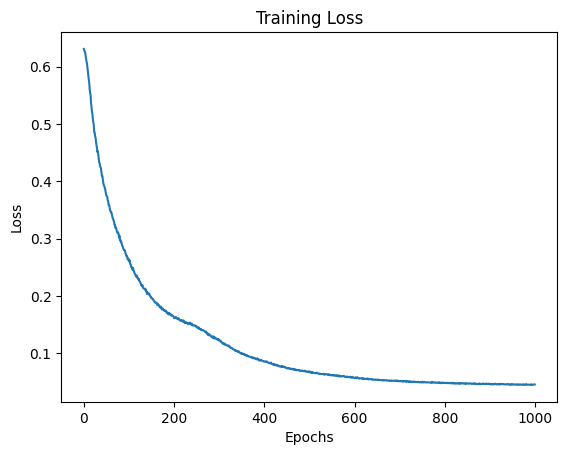

In [84]:
train(model,model_weights_dataloader)

In [116]:
def global_predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]  
            outputs = model(inputs.unsqueeze(1))
            predictions.append(outputs.detach().numpy())
    return np.vstack(predictions)

In [117]:
predictions_global = global_predict(model, model_weights_dataloader)

In [119]:
predictions_global[-1]

array([11.668098], dtype=float32)